# Assignment 2

Demostrate consequences of No Free Lunch Theorem: every model of machine learning makes **assumptions** about dataset properties. If the assumption fails, model perfoms badly. If the assumption is met, model perfoms good.

For each of the tasks, described below:
1. create a dataset to meet the description. For demonstration purposes, feature dimension size = 2    
1. train the models and evaluate accuracy. (with a training pipeline, described in the seminar) 
1. Show which model is better.   
1. Write what assumptions were used, and why model exibits such behavior.  
1. Plot dataset to demonstrate its properties. (Scatter plot, classes with different colors)  


Tasks:

1. Create dataset for binary classification task (binary crossentropy), 
where k-NN perfoms **worse** than logistic regression

2. Create dataset for binary classification task (binary crossentropy), 
where logistic regression perfoms **worse** than k-NN

3. Create dataset for binary classification task (binary crossentropy), 
where k-NN with cosine distance perfoms **better** than k-NN with euclidean distance


! If there is no explanation, why one model perfoms better than the other on your dataset, the task does not count.  
! if the training pipeline is not used, the task does not count.  

In [0]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from random import uniform

# Fixing random state for reproducibility
np.random.seed(19680801)

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [0]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

Подбор гиперпараметров для пайплайна:

In [0]:
def optimal_estimator(model, X_train, Y_train, params, cvfolds=10):
    gs = GridSearchCV(model, param_grid=params, cv=cvfolds)
    gs.fit(X_train, Y_train)
    print("Best parameters:", gs.best_estimator_)
    return gs.best_estimator_

## Case 1

*Create dataset for binary classification task (binary crossentropy), where k-NN perfoms worse than logistic regression*

Метод k-NN хорошо разделяет кластеры, в которых соседние элементы близко друг другу (где расстояние между ними в целом меньше, чем среднее расстояние между кластерами). Логистическая регрессия же подразумевает, что кластеры можно разделить линейной функцией — прямой линией на графике. Соответственно, чтобы регрессия сработала лучше, чем k-NN, следует подобрать такие кластеры, которые хотя бы в некоторой части будут значительно близко друг к другу (так, чтобы расстояние между кластерами было меньше, чем расстояние между их элементами), но при этом кластеры были бы хорошо линейно разделимы.

Для этой цели сформируем два кластера, основанных на параболах, лежащих близко друг к другу (осложнение для k-NN), но отражённых относительно y=0 (линейное разделение для LogReg).

In [0]:
num_samples = 400

type1 = [(i - int(num_samples / 2), (i - int(num_samples / 2))**2 / 10000) for i in range(num_samples)]
type1 = np.array(type1)
type2 = [(i - int(num_samples / 2), -(i - int(num_samples / 2))**2 / 10000) for i in range(num_samples)]
type2 = np.array(type2)

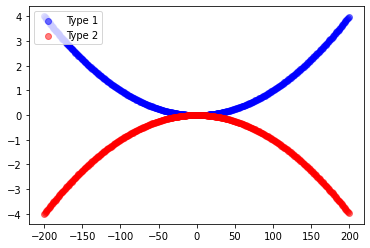

In [6]:
%matplotlib inline

plt.scatter(type1[:, 0], type1[:, 1], c="b", alpha=0.5, label="Type 1")
plt.scatter(type2[:, 0], type2[:, 1], c="r", alpha=0.5, label="Type 2")
plt.legend(loc='upper left')
plt.show()

In [0]:
X = np.concatenate((type1, type2))
Y = np.array([0] * num_samples + [1] * num_samples)
X, Y = unison_shuffled_copies(X, Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42)

In [8]:
%%time

knn = optimal_estimator(KNeighborsClassifier(), X, Y,
                        {"n_neighbors": list(range(1, int(len(X) / 2)))})
knn.fit(X_train, Y_train)

Best parameters: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')
CPU times: user 23.9 s, sys: 30 ms, total: 23.9 s
Wall time: 24 s


Best KNN accuracy on test: 0.875


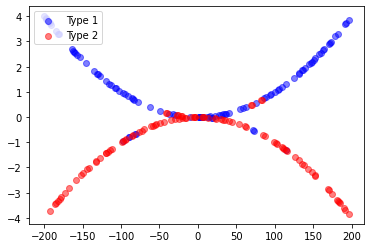

In [9]:
%matplotlib inline

prediction = knn.predict(X_test)
print("Best KNN accuracy on test:", accuracy_score(Y_test, prediction))

type1_test = X_test[[i==0 for i in prediction]]
type2_test = X_test[[i==1 for i in prediction]]
plt.scatter(type1_test[:, 0], type1_test[:, 1], c="b", alpha=0.5, label="Type 1")
plt.scatter(type2_test[:, 0], type2_test[:, 1], c="r", alpha=0.5, label="Type 2")
plt.legend(loc='upper left')
plt.show()

In [10]:
%%time

lr = optimal_estimator(LogisticRegression(), X, Y,
                        {"tol": [1, 0.1, 0.01, 0.001, 0.0001], 
                         "C": [0.1, 1, 10, 100],
                         "solver": ["newton-cg", "lbfgs", "liblinear"]})
lr.fit(X_train, Y_train)

Best parameters: LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=1, verbose=0,
                   warm_start=False)
CPU times: user 3.3 s, sys: 1.99 ms, total: 3.3 s
Wall time: 3.32 s


Best LR accuracy on test: 0.965


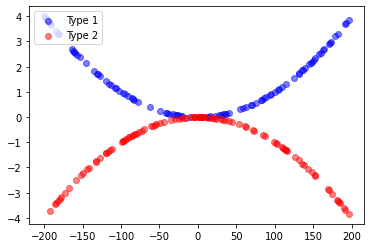

In [11]:
%matplotlib inline

prediction = lr.predict(X_test)
print("Best LR accuracy on test:", accuracy_score(Y_test, prediction))

type1_test = X_test[[i==0 for i in prediction]]
type2_test = X_test[[i==1 for i in prediction]]
plt.scatter(type1_test[:, 0], type1_test[:, 1], c="b", alpha=0.5, label="Type 1")
plt.scatter(type2_test[:, 0], type2_test[:, 1], c="r", alpha=0.5, label="Type 2")
plt.legend(loc='upper left')
plt.show()

Итак, на графиках видно, что k-NN ошибается в части, где кластеры близко подходят друг другу и расстояние между кластерами зачастую меньше, чем между элементами, в то время как логистическая регрессия практически верно нашла линию раздела и, соответственно, работает лучше.

## Case 2

*Create dataset for binary classification task (binary crossentropy), where logistic regression perfoms worse than k-NN*

В противоположной задаче нам следует подобрать два кластера, которые невозможно разделить линейно (прямой линией, осложнение для LogReg), и элементы внутри которых были бы существенно ближе, чем среднее расстояние между графиками (что соответствует assumption метода k ближайших соседей). Сгруппируем наши элементы вдоль синусной и косинусной функций — так, чтобы максимумы функций совпадали и один из кластеров на графике оказался "внутри" другого.

In [0]:
from math import pi, sin, cos

In [0]:
num_samples = 400

type1 = [(x, -cos(x)) for x in np.linspace(-pi, pi, num=num_samples)]
type1 = np.array(type1)
type2 = [(x, sin(x + pi/2)) for x in np.linspace(-1, 1, num=num_samples)]
type2 = np.array(type2)

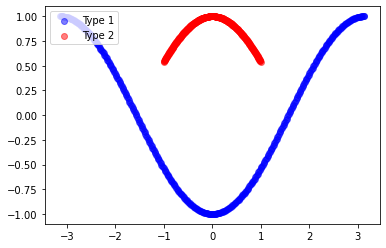

In [14]:
%matplotlib inline

plt.scatter(type1[:, 0], type1[:, 1], c="b", alpha=0.5, label="Type 1")
plt.scatter(type2[:, 0], type2[:, 1], c="r", alpha=0.5, label="Type 2")
plt.legend(loc='upper left')
plt.show()

In [0]:
X = np.concatenate((type1, type2))
Y = np.array([0] * num_samples + [1] * num_samples)
X, Y = unison_shuffled_copies(X, Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42)

In [16]:
%%time

knn = optimal_estimator(KNeighborsClassifier(), X, Y,
                        {"n_neighbors": list(range(1, int(len(X) / 2)))})
knn.fit(X_train, Y_train)

Best parameters: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')
CPU times: user 24.7 s, sys: 8.87 ms, total: 24.7 s
Wall time: 24.7 s


Best KNN accuracy on test: 1.0


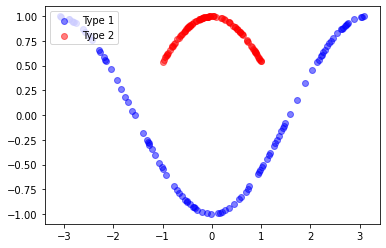

In [17]:
%matplotlib inline

prediction = knn.predict(X_test)
print("Best KNN accuracy on test:", accuracy_score(Y_test, prediction))

type1_test = X_test[[i==0 for i in prediction]]
type2_test = X_test[[i==1 for i in prediction]]
plt.scatter(type1_test[:, 0], type1_test[:, 1], c="b", alpha=0.5, label="Type 1")
plt.scatter(type2_test[:, 0], type2_test[:, 1], c="r", alpha=0.5, label="Type 2")
plt.legend(loc='upper left')
plt.show()

In [18]:
%%time

lr = optimal_estimator(LogisticRegression(), X, Y,
                        {"tol": [1, 0.1, 0.01, 0.001, 0.0001], 
                         "C": [0.1, 1, 10, 100],
                         "solver": ["newton-cg", "lbfgs", "liblinear"]})
lr.fit(X_train, Y_train)

Best parameters: LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=1, verbose=0,
                   warm_start=False)
CPU times: user 1.96 s, sys: 2.95 ms, total: 1.97 s
Wall time: 1.97 s


Best LR accuracy on test: 0.805


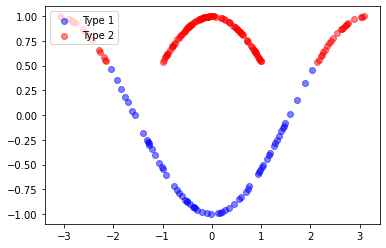

In [19]:
%matplotlib inline

prediction = lr.predict(X_test)
print("Best LR accuracy on test:", accuracy_score(Y_test, prediction))

type1_test = X_test[[i==0 for i in prediction]]
type2_test = X_test[[i==1 for i in prediction]]
plt.scatter(type1_test[:, 0], type1_test[:, 1], c="b", alpha=0.5, label="Type 1")
plt.scatter(type2_test[:, 0], type2_test[:, 1], c="r", alpha=0.5, label="Type 2")
plt.legend(loc='upper left')
plt.show()

Видим, что логистическая регрессия попыталась провести наиболее удачное линейное разделение, которое, тем не менее, захватило хвосты функции косинуса. Метод k-NN же справился с задачей со 100%-ной точностью, верно разделив соответствующие разноудалённые кластеры.

## Case 3

*Create dataset for binary classification task (binary crossentropy), where k-NN with cosine distance perfoms better than k-NN with euclidean distance*

k-NN с евклидовым расстоянием подразумевает минимальное расстояние между точками, в то время как k-NN с косинусным расстоянием подразумевает минимальное расстояние между соответствующим элементам массива векторам. Так, косинусное расстояние между элементами `(a, b)` и `(a*n, b*n)` будет равно нулю, а евклидово расстояние будет коррелировать с величиной `n`. Соответственно, для того, чтобы k-NN с косинусным расстоянием отработал лучше, необходимо подобрать такие кластеры, которые будут довольно близки друг к другу и в одном из которых косинусное расстояние между любыми двумя точками будет минимально — например, на y=0. 

In [0]:
num_samples = 400

type1 = [(x, 0) for x in np.linspace(-pi*4, pi*4, num=num_samples)]
type1 = np.array(type1)
type2 = [(x, 0.1 * cos(x) + 0.105) for x in np.linspace(-pi*4, pi*4, num=num_samples)]
type2 = np.array(type2)

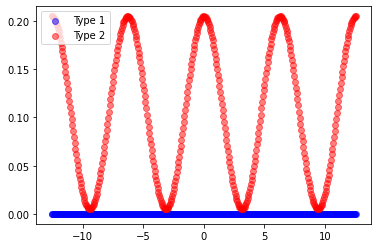

In [21]:
%matplotlib inline

plt.scatter(type1[:, 0], type1[:, 1], c="b", alpha=0.5, label="Type 1")
plt.scatter(type2[:, 0], type2[:, 1], c="r", alpha=0.5, label="Type 2")
plt.legend(loc='upper left')
plt.show()

In [0]:
X = np.concatenate((type1, type2))
Y = np.array([0] * num_samples + [1] * num_samples)
X, Y = unison_shuffled_copies(X, Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42)

In [29]:
%%time

knn = optimal_estimator(KNeighborsClassifier(metric="cosine"), X, Y,
                        {"n_neighbors": list(range(1, int(len(X) / 2)))})
knn.fit(X_train, Y_train)

Best parameters: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='cosine',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')
CPU times: user 21.9 s, sys: 65.8 ms, total: 21.9 s
Wall time: 22 s


Best cosine KNN accuracy on test: 1.0


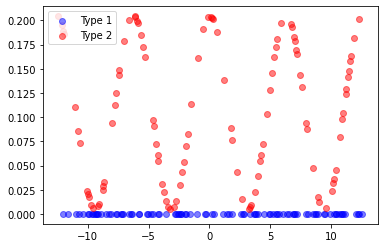

In [30]:
%matplotlib inline

prediction = knn.predict(X_test)
print("Best cosine KNN accuracy on test:", accuracy_score(Y_test, prediction))

type1_test = X_test[[i==0 for i in prediction]]
type2_test = X_test[[i==1 for i in prediction]]
plt.scatter(type1_test[:, 0], type1_test[:, 1], c="b", alpha=0.5, label="Type 1")
plt.scatter(type2_test[:, 0], type2_test[:, 1], c="r", alpha=0.5, label="Type 2")
plt.legend(loc='upper left')
plt.show()

In [25]:
%%time

knn = optimal_estimator(KNeighborsClassifier(metric="euclidean"), X, Y,
                        {"n_neighbors": list(range(1, int(len(X) / 2)))})
knn.fit(X_train, Y_train)

Best parameters: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')
CPU times: user 23.9 s, sys: 11.1 ms, total: 23.9 s
Wall time: 23.9 s


Best euclidean KNN accuracy on test: 0.805


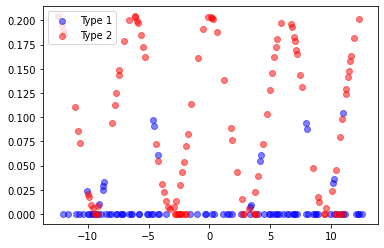

In [27]:
%matplotlib inline

prediction = knn.predict(X_test)
print("Best euclidean KNN accuracy on test:", accuracy_score(Y_test, prediction))

type1_test = X_test[[i==0 for i in prediction]]
type2_test = X_test[[i==1 for i in prediction]]
plt.scatter(type1_test[:, 0], type1_test[:, 1], c="b", alpha=0.5, label="Type 1")
plt.scatter(type2_test[:, 0], type2_test[:, 1], c="r", alpha=0.5, label="Type 2")
plt.legend(loc='upper left')
plt.show()

Как мы и ожидали, k-NN с косинусным расстоянием отработал с высокой точностью, в то время как k-NN с евклидовым расстоянием имеет существенно более низкую точность и неверно определяет элементы разных классов из-за близости кластеров.